In [1]:
%reset -f
from pythonrc import *

In [2]:
def initialize_allocator(
    allocator_type: skadipy.allocator.AllocatorBase, **kwargs
) -> skadipy.allocator.AllocatorBase:
    return allocator_type(
        actuators=[
            tunnel,
            voithschneider_port,
            voithschneider_starboard,
        ],
        force_torque_components=[
            skadipy.allocator.ForceTorqueComponent.X,
            skadipy.allocator.ForceTorqueComponent.Y,
            skadipy.allocator.ForceTorqueComponent.N,
        ],
        **kwargs,
    )


time_step = 0.1

gamma = [1e-1, 1e-3, 1e-5]
mu = [1e-1, 1e-1, 1e-1]
rho = [1e-1, 1e-1, 1e-1]
zeta = [1.0, 1.0, 1.0]
lambda_p = [0.9, 0.9, 0.9]

markdown_table = generate_markdown_table(
    gamma, mu, rho, zeta, lambda_p,
)
display(Markdown(markdown_table))

| | $\gamma$ | $\mu$ | $\rho$ | $\zeta$ | $\lambda_i$ |
|--|-------|----|-----|------|----------|
| Run 0| 0.1 | 0.1 | 0.1 | 1.0 | 0.9 |
| Run 1| 0.001 | 0.1 | 0.1 | 1.0 | 0.9 |
| Run 2| 1e-05 | 0.1 | 0.1 | 1.0 | 0.9 |


In [3]:
def initialize_allocators():
    a = []
    for i in range(3):
        a.append(
            initialize_allocator(
                skadipy.allocator.reference_filters.MinimumMagnitudeAndAzimuth,
                gamma=gamma[i],
                mu=mu[i],
                rho=rho[i],
                zeta=zeta[i],
                lambda_=lambda_p[i],
                time_step=time_step,
            )
        )
    return a

(<Figure size 800x800 with 3 Axes>,
 array([<Axes: xlabel='Time [s]', ylabel='$F_x$ [N]'>,
        <Axes: xlabel='Time [s]', ylabel='$F_y$ [N]'>,
        <Axes: xlabel='Time [s]', ylabel='$M_z$ [N]'>], dtype=object))

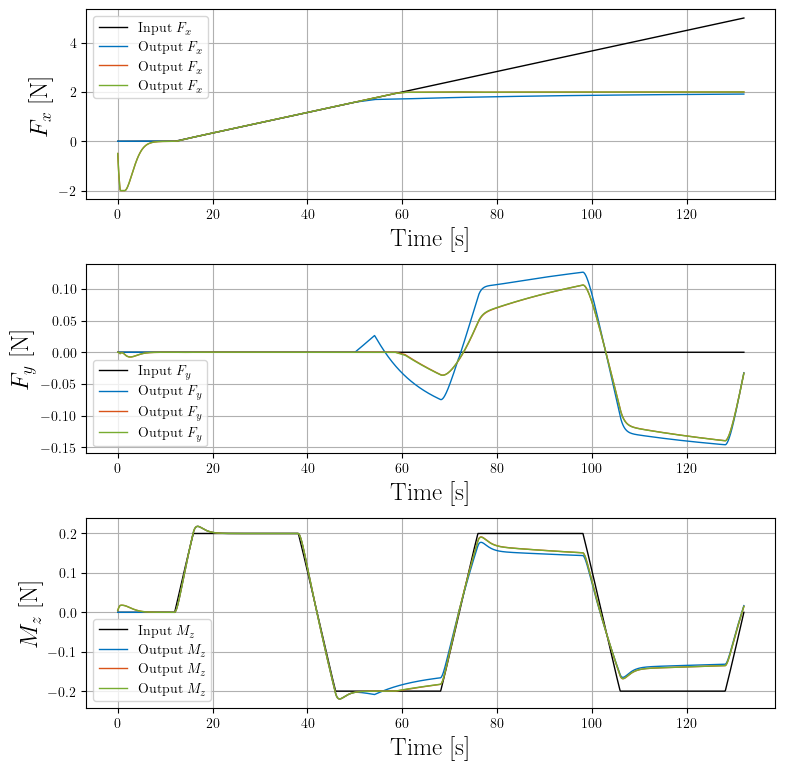

In [4]:
n = 1200
tau_cmd = np.zeros((n, 6))
tau_cmd[:,0] = np.linspace(0, 5, n)
tau_cmd[:,5] = gen_clipped_sin(n, 0.5, 2.0, 0.0, 0, -0.2, 0.2)
tau_cmd = np.concatenate((np.zeros((int(n/10), 6)), tau_cmd))

xi_hist, theta_hist, tau_hist = run_tests(tau_cmd, allocators=initialize_allocators())
plot_histories(tau_cmd=tau_cmd, tau_alloc=tau_hist, dt=time_step)

(<Figure size 800x800 with 3 Axes>,
 array([<Axes: xlabel='Time [s]', ylabel='Tunnel [N]'>,
        <Axes: xlabel='Time [s]', ylabel='Port [N]'>,
        <Axes: xlabel='Time [s]', ylabel='Starboard [N]'>], dtype=object))

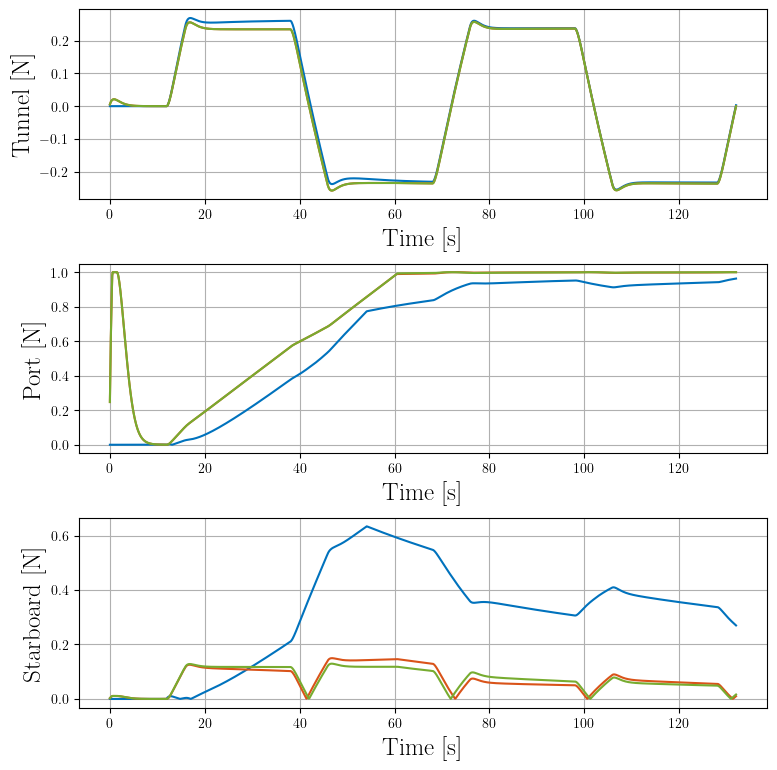

In [5]:
plot_thruster_forces(xi_hist, dt=time_step)

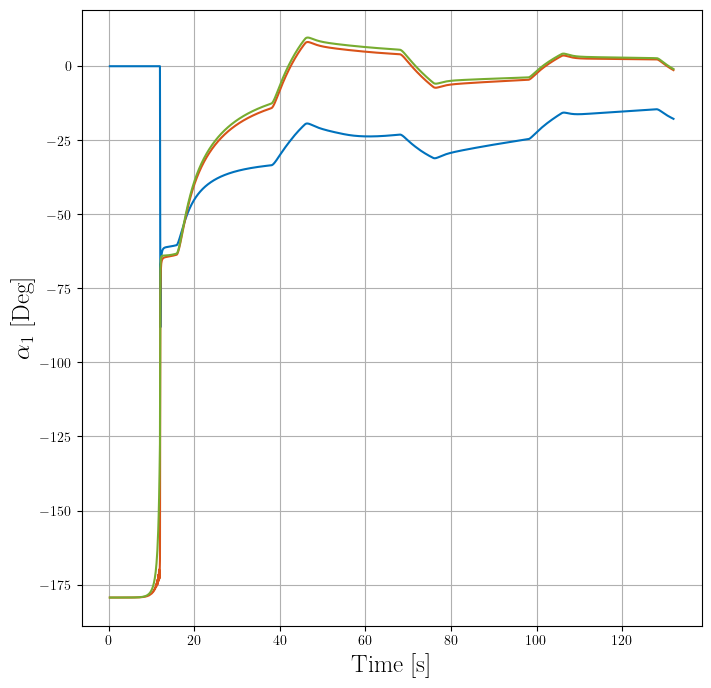

In [6]:
plot_angles(xi_hist, dt=time_step)


plt.grid(True)

(<Figure size 800x800 with 3 Axes>,
 array([<Axes: xlabel='Time [s]', ylabel='$\\theta_2$'>,
        <Axes: xlabel='Time [s]', ylabel='$\\theta_1$'>,
        <Axes: xlabel='Time [s]', ylabel='$\\theta_2$'>], dtype=object))

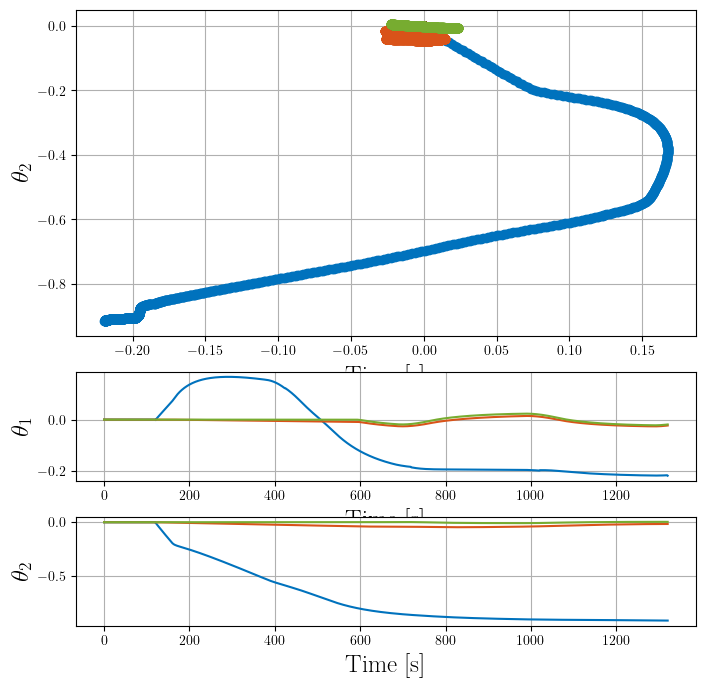

In [7]:
plot_theta_histories(theta_hist=theta_hist)

In [8]:
save_mat(
    filename="data/013.mat",
    dt=time_step,
    inputs=tau_cmd,
    xi=xi_hist,
    thetas=theta_hist,
    outputs=tau_hist,
    zeta=zeta,
    rho=rho,
    gamma=gamma,
    mu=mu,
    lambda_p=lambda_p,
    thruster=voithschneider_port
)